In [1]:
import torch
from torch import nn
import d2l_torch as d2l
from torch.nn import functional as F

+ args 是 arguments 的缩写，表示位置参数；
+ kwargs 是 keyword arguments 的缩写，表示关键字参数。
+ 这其实就是 Python 中可变参数的两种形式，并且 *args 必须放在 **kwargs 的前面，因为位置参数在关键字参数的前面。
+ https://www.jianshu.com/p/0ed914608a2c
+ **kwargs表示，除了前面显示接收的参数外，其他参数以dict结构进行接收（可以认为显示接收的参数是必须的，**kwargs接收的参数是可选的）
+ *vars表示解包元组，**vars表示解包字典，使用这种语法可以传递不定长参数

In [2]:
class Inception(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1) # 第二条路的第一层  p表示path
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        self.p3_1=nn.Conv2d(in_channels,c3[0],kernel_size=1) 
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_channels,c4,kernel_size=1)
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2( F.relu(self.p2_1(x))) )
        p3=F.relu(self.p3_2( F.relu(self.p3_1(x))) )
        p4=F.relu(self.p4_2(self.p4_1(x)) ) 
        return torch.cat((p1,p2,p3,p4),dim=1) # dim=0是batch_size,dim=1是channel 在channel上进行堆叠，相当于把通道数合并在一起了

In [3]:
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
b2=nn.Sequential(nn.Conv2d(64,64,kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(64,192,kernel_size=3,padding=1),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
# 确实很奇怪，这里第二个卷积层后面每月跟上激活函数。。。（最大池化其实可以认为是一种非线性操作？？？）❓❓❓
b3=nn.Sequential(Inception(in_channels=192,c1=64,c2=(96,128),c3=(16,32),c4=32),
                Inception(in_channels=256,c1=128,c2=(128,192),c3=(32,96),c4=64),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
                )

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net=nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

为了可以简单训练，把224的输入变成了96

In [4]:
X=torch.rand((1,1,96,96))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,"output shape:\t",X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [5]:
X=torch.rand((1,1,96,96))
i=0
for group in net:
    i+=1
    if i<6:
        for layer in group:
            X=layer(X)
            print(layer.__class__.__name__,"output shape:\t",X.shape)
    else:
        X=group(X)
        print(group.__class__.__name__,"output shape:\t",X.shape)
        break
        
# layer=net[6]
# X=layer(X)
# print(layer.__class__.__name__,"output shape:\t",X.shape)

Conv2d output shape:	 torch.Size([1, 64, 48, 48])
ReLU output shape:	 torch.Size([1, 64, 48, 48])
MaxPool2d output shape:	 torch.Size([1, 64, 24, 24])
Conv2d output shape:	 torch.Size([1, 64, 24, 24])
ReLU output shape:	 torch.Size([1, 64, 24, 24])
Conv2d output shape:	 torch.Size([1, 192, 24, 24])
MaxPool2d output shape:	 torch.Size([1, 192, 12, 12])
Inception output shape:	 torch.Size([1, 256, 12, 12])
Inception output shape:	 torch.Size([1, 480, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 480, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 528, 6, 6])
Inception output shape:	 torch.Size([1, 832, 6, 6])
MaxPool2d output shape:	 torch.Size([1, 832, 3, 3])
Inception output shape:	 torch.Size([1, 832, 3, 3])
Inception output shape:	 torch.Size([1, 1024, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 1024, 1, 1])
Flatten 

loss 0.243, train acc 0.908, test acc 0.890
568.3 examples/sec on cuda:0


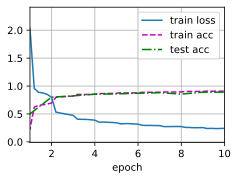

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())